<a href="https://colab.research.google.com/github/hwon820/Python_DataAnalysis/blob/main/chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##041. 데이터 불러오기 및 수정

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import pandas as pd
customer = pd.read_csv("/content/gdrive/MyDrive/파이썬 데이터분석/pyda100-master/5장/customer_join.csv")
uselog_months = pd.read_csv("/content/gdrive/MyDrive/파이썬 데이터분석/pyda100-master/5장/use_log_months.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [ ]:
#이달과 1개월 전의 이용횟수 집계 데이터 ->  지난주에 한 6개월분의 데이터를 이용한 예측은 탈퇴회원/가입기간 6개월 미만 회원으로 인해 의미X
year_months = list(uselog_months["연월"].unique())
uselog = pd.DataFrame()
for i in range(1,len(year_months)):
  #현재 i가 가리키는 연월과 같은 연월을 가진 이용내력들을 tmp에 담음
  tmp = uselog_months.loc[uselog_months["연월"] == year_months[i]]
  tmp.rename(columns = {"count" : "count_0"}, inplace = True)
  
  #현재 i가 가리키는 연월의 이전 연월과 같은 연월을 가진 이용내력들을 tmp_before에 담음
  tmp_before = uselog_months.loc[uselog_months["연월"] == year_months[i - 1]]
  del tmp_before["연월"]  #tmp_before의 연월은 merge했을 때 중복되므로 제거
  tmp_before.rename(columns = {"count" : "count_1"}, inplace = True)

  #customer_id를 기준으로 merge -> 각 고객의 월별 이용내력 & 1달 전 이용내력을 알 수 있음
  tmp = pd.merge(tmp, tmp_before, on = "customer_id", how = "left")
  uselog = pd.concat([uselog, tmp], ignore_index = True)

uselog.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,연월,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


##042. 탈퇴 전 월의 탈퇴 고객 데이터 작성

In [ ]:
#탈퇴신청을 한 다음 달 말에 탈퇴가 이루어지므로. 탈퇴 신청이 완료된 이후의 달은 더이상 탈퇴를 막을 수 없음. -> 따라서 탈퇴 전 달을 봄

#탈퇴 회원 추출
from dateutil.relativedelta import relativedelta
exit_customer = customer.loc[customer["is_deleted"] == 1]


exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])

#enddate의 1개월 전 계산해서 exit_date(탈퇴신청 날짜)에 삽입
for i in range(len(exit_customer)):
  exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months = 1)

exit_customer["연월"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")
uselog["연월"] = uselog["연월"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on =["customer_id", "연월"], how = "left")
print(len(uselog))
exit_uselog.head()

#탈퇴 전월의 데이터 뿐이라 결측치가 다수 나타남

<ipython-input-32-43b78edd3729>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["exit_date"] = None
<ipython-input-32-43b78edd3729>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

33851


<ipython-input-32-43b78edd3729>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["연월"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#결측치 제거
exit_uselog = exit_uselog.dropna(subset = ["name"])   #subset: 특정 column에 있는 결측치만 삭제
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


##043. 지속 회원 데이터 작성


In [ ]:
conti_customer = customer.loc[customer["is_deleted"] == 0]
conti_uselog = pd.merge(uselog, conti_customer, on = ["customer_id"], how = "left")
print(len(conti_uselog))  #탈퇴 회원, 결측치 제거 전 데이터 개수
conti_uselog = conti_uselog.dropna(subset = ["name"])
print(len(conti_uselog))  #제거 후 데이터 개수

#탈퇴 데이터 1104개 / 유지 데이터 27422개 -> 불균형

33851
27422


In [ ]:
#데이터 불균형 방지를 위한 언더샘플링
#DataFrame.sample(): 랜덤 추출 method
#frac: 전체 개수의 비율만큼 샘플 반환

#회원당 데이터가 1개가 되도록 언더샘플링
conti_uselog = conti_uselog.sample(frac = 1).reset_index(drop = True)
#Dataframe.drop_duplicates(): 내용이 중복되는 행 제거
conti_uselog = conti_uselog.drop_duplicates(subset = "customer_id")
print(len(conti_uselog))
conti_uselog.head()

#유지 데이터 2842개로 감소

2842


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201812,HI866614,7,8.0,XXXXX,C02,M,2018-05-01,NaN,CA2,...,주간,7500.0,입회비반액할인,8.000000,8.0,11.0,6.0,1.0,2019-04-30,11.0
1,201809,HD707231,5,8.0,XXX,C03,F,2017-08-01,NaN,CA2,...,야간,6000.0,입회비반액할인,7.166667,7.0,12.0,5.0,1.0,2019-04-30,20.0
2,201805,AS404195,6,7.0,XXX,C01,F,2017-02-01,NaN,CA1,...,종일,10500.0,일반,4.916667,5.5,7.0,2.0,1.0,2019-04-30,26.0
3,201810,AS108507,6,6.0,XX,C03,M,2016-12-01,NaN,CA1,...,야간,6000.0,일반,6.333333,6.0,9.0,4.0,1.0,2019-04-30,28.0
4,201902,TS044469,7,7.0,XXXX,C02,F,2017-02-01,NaN,CA1,...,주간,7500.0,일반,6.500000,6.5,8.0,5.0,1.0,2019-04-30,26.0


In [ ]:
#지속 데이터와 탈퇴 데이터 결합
#세로로 결합

predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index = True)
print(len(predict_data))
predict_data.head()

#1104 + 2842 = 3946

3946


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201812,HI866614,7,8.0,XXXXX,C02,M,2018-05-01,NaN,CA2,...,7500.0,입회비반액할인,8.000000,8.0,11.0,6.0,1.0,2019-04-30,11.0,NaN
1,201809,HD707231,5,8.0,XXX,C03,F,2017-08-01,NaN,CA2,...,6000.0,입회비반액할인,7.166667,7.0,12.0,5.0,1.0,2019-04-30,20.0,NaN
2,201805,AS404195,6,7.0,XXX,C01,F,2017-02-01,NaN,CA1,...,10500.0,일반,4.916667,5.5,7.0,2.0,1.0,2019-04-30,26.0,NaN
3,201810,AS108507,6,6.0,XX,C03,M,2016-12-01,NaN,CA1,...,6000.0,일반,6.333333,6.0,9.0,4.0,1.0,2019-04-30,28.0,NaN
4,201902,TS044469,7,7.0,XXXX,C02,F,2017-02-01,NaN,CA1,...,7500.0,일반,6.500000,6.5,8.0,5.0,1.0,2019-04-30,26.0,NaN


##044. 예측할 달의 재적 기간 작성

In [ ]:
#재적 기간: 현재 날짜 ~ 시작 날짜 차이
predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format = "%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

for i in range(len(predict_data)):
  delta = relativedelta(predict_data["now_date"][i] - predict_data["start_date"][i])
  predict_data["period"][i] = int(delta.years*12 + delta.months)

predict_data.head()

<ipython-input-37-86ea619dbd25>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = int(delta.years*12 + delta.months)


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201812,HI866614,7,8.0,XXXXX,C02,M,2018-05-01,NaN,CA2,...,8.000000,8.0,11.0,6.0,1.0,2019-04-30,11.0,NaN,0,2018-12-01
1,201809,HD707231,5,8.0,XXX,C03,F,2017-08-01,NaN,CA2,...,7.166667,7.0,12.0,5.0,1.0,2019-04-30,20.0,NaN,0,2018-09-01
2,201805,AS404195,6,7.0,XXX,C01,F,2017-02-01,NaN,CA1,...,4.916667,5.5,7.0,2.0,1.0,2019-04-30,26.0,NaN,0,2018-05-01
3,201810,AS108507,6,6.0,XX,C03,M,2016-12-01,NaN,CA1,...,6.333333,6.0,9.0,4.0,1.0,2019-04-30,28.0,NaN,0,2018-10-01
4,201902,TS044469,7,7.0,XXXX,C02,F,2017-02-01,NaN,CA1,...,6.500000,6.5,8.0,5.0,1.0,2019-04-30,26.0,NaN,0,2019-02-01


##045. 결측치 처리

In [ ]:
#결측치 개수 확인
predict_data.isna().sum()

#count_1
#end_date, exit_date -> 탈퇴 회원에게만 존재해서 유지 회원에겐 결측치

연월                      0
customer_id             0
count_0                 0
count_1               257
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [ ]:
#count_1 결손된 데이터 처리

predict_data = predict_data.dropna(subset = ["count_1"])
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2637
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2637
period                  0
now_date                0
dtype: int64

##046. 문자열 변수 가공

In [ ]:
#문자열 데이터 -> in 카테고리 변수

#예측에 사용할 데이터 추출 (목적 변수: is_deleted)
target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,입회비반액할인,주간,M,8.0,1.0,0,0.0
1,입회비반액할인,야간,F,8.0,1.0,0,0.0
2,일반,종일,F,7.0,1.0,0,0.0
3,일반,야간,M,6.0,1.0,0,0.0
4,일반,주간,F,7.0,1.0,0,0.0


In [ ]:
#더미 변수 만들기: 독립변수를 0과 1로 변환한 변수(범주형 변수를 연속형 변수스럽게 변경)
#get_dummies(): 일괄적으로 더미 변수 생성
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_일반,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_야간,class_name_종일,class_name_주간,gender_F,gender_M
0,8.0,1.0,0,0.0,0,0,1,0,0,1,0,1
1,8.0,1.0,0,0.0,0,0,1,1,0,0,1,0
2,7.0,1.0,0,0.0,1,0,0,0,1,0,1,0
3,6.0,1.0,0,0.0,1,0,0,1,0,0,0,1
4,7.0,1.0,0,0.0,1,0,0,0,0,1,1,0


In [ ]:
#각 더미 변수가 겹칠땐 하나만 남기고 삭제
del predict_data["campaign_name_일반"]
del predict_data["class_name_야간"]
del predict_data["gender_M"]
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_종일,class_name_주간,gender_F
0,8.0,1.0,0,0.0,0,1,0,1,0
1,8.0,1.0,0,0.0,0,1,0,0,1
2,7.0,1.0,0,0.0,0,0,1,0,1
3,6.0,1.0,0,0.0,0,0,0,0,0
4,7.0,1.0,0,0.0,0,0,0,1,1


##047. Decision Tree를 사용한 탈퇴 예측 모델

###DecisionTree: 일련의 분류 규칙을 통해 데이터를 분류, 회귀하는 지도 학습 모델
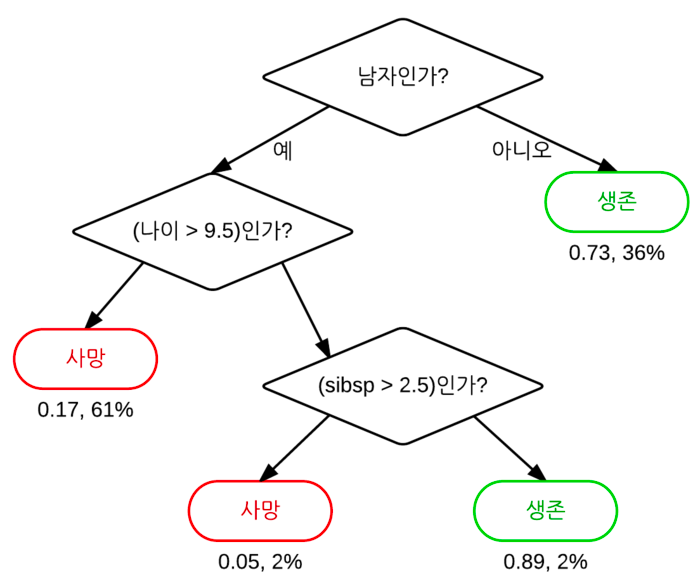

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

exit = predict_data.loc[predict_data["is_deleted"]==1]
#유지 데이터에서 탈퇴 데이터 개수만큼 임의로 추출
conti = predict_data.loc[predict_data["is_deleted"]==0].sample(len(exit))

X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
#학습 / 검증 데이터 분할
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.

In [ ]:
#정답과 비교 -> 한 데이터프레임에 저장
results_test = pd.DataFrame({"y_test": y_test, "y_pred": y_test_pred})
results_test.head()

,y_test,y_pred
196,1.0,1.0
742,1.0,1.0
389,1.0,0.0
124,1.0,1.0
1853,0.0,0.0


##048. 예측모델 평가 및 튜닝

In [ ]:
#정답률 계산
correct = len(results_test.loc[results_test["y_test"] == results_test["y_pred"]]) #일치하는 데이터 개수
data_count = len(results_test)  #전체 데이터 개수
score_test = correct / data_count
print(score_test)

#0.84

0.8498098859315589


In [ ]:
#함수를 이용한 정답률 계산
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

#학습용 데이터에 과적합된 경향...?

0.8498098859315589
0.8726235741444867


### Parameter Tuning


*   데이터 증강
*   변수 재검토
*   hyperparameter 변경






In [ ]:
X = pd.concat([exit, conti], ignore_index = True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

model = DecisionTreeClassifier(random_state = 0, max_depth = 5) #max_depth: 지정하면 모델 단순화
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

#검증용 데이터의 정답률 증가
#학습용 데이터의 정답률 감소

0.8504435994930292
0.8688212927756654


##049. 모델에 기여하는 변수 확인

In [ ]:
importance = pd.DataFrame({"feature_names": X.columns, "coefficient": model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.347325
1,routine_flg,0.494867
2,period,0.000000
3,campaign_name_입회비무료,0.075868
4,campaign_name_입회비반액할인,0.079124
5,class_name_종일,0.001343
6,class_name_주간,0.000743
7,gender_F,0.000731


##050. 회원 탈퇴 예측

In [ ]:
#어떤 회원 정의
count_1 = 3
routine_flg = 1
period = 10
campaign_name = "입회비무료"
class_name = "종일"
gender = "M"

In [ ]:
#데이터 가공 - 데이터 분기 후 더미 변수로 작성
if campaign_name == "입회비반값할인":
  campaign_name_list = [1, 0]
elif campaign_name == "입회비무료":
  campaign_name_list = [0, 1]
elif campaign_name == "일반":
  campaign_name_list = [0, 0]
if class_name == "종일":
  class_name_list = [1, 0]
elif class_name == "주간":
  class_name_list = [0, 1]
elif class_name == "야간":
  class_name_list = [0, 0]
if gender == "F":
  gender_list = [1]
elif gender == "M":
  gender_list = [0]

input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

In [ ]:
print(model.predict([input_data]))
print(model.predict_proba([input_data]))

# 1 -> 탈퇴 예상
# 0.06493506: 0의 확률(유지 확률)  |  0.93506494: 1의 확률(탈퇴 확률)

[1.]
[[0.06493506 0.93506494]]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
